# Calculate CO2e intensity for the Ontario grid

Try to calculate the grid intensity from publically available data to see if we can match the data provided by gridwatch. See [issue #1](https://github.com/ryanfobel/gridwatch-history/issues/1) on github.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

sys.path.insert(0, os.path.join(".."))

# Change to the parent directory so that data files are stored in the right place
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import arrow

%matplotlib inline

rcParams.update({"figure.figsize": (12, 6)})

def parse_index_as_datetime(df, year):
    # Parse index as datetimes
    if type(df.index) != pd.core.indexes.datetimes.DatetimeIndex:
        df.index = [arrow.get(str(year) + ' ' + d, 'YYYY ddd MMM DD, H A').datetime for d in df.index]
    return df

# Load data

# Donwload CARMA database here: https://www.cgdev.org/sites/default/files/CARMAv30_PowerUser.zip
df_carma = pd.read_csv('data/CARMAv30_PowerUser/Plant.csv', low_memory=False)
df_summary = pd.read_csv("data/summary.csv", index_col=0, thousands=',')
df_capability = pd.read_csv("data/capability.csv", thousands=',')
df_plants = pd.read_csv("data/plants.csv")
df_output = pd.read_csv("data/output.csv", index_col=0, thousands=',')

# Get a list of all of the gas plants
gas_plants = df_plants[df_plants['source'] == 'gas']['name'].values

# Remove plants that have note output
gas_plants = gas_plants[df_output[gas_plants].sum() > 1].tolist()

parse_index_as_datetime(df_output[gas_plants].tail(), 2022)

,(DOWCHEM) SARNIA,BRIGHTON BEACH,CARDINAL,DUPONT,EAST WINDSOR-1,EAST WINDSOR-2,GREENFIELD SOUTH-1,GREENFIELD SOUTH-2,GREENFIELD-1,GREENFIELD-2,...,SITHE GOREWAY-15,ST. CLAIR SARNIA,THOROLD COGEN,TRANSALTA OTTAWA,TRANSALTA SARNIA,TRANSALTA WINDSOR,TUNIS,WINDSOR COGEN,YORK COGEN 1,YORK COGEN 2
2022-06-23 12:00:00+00:00,10,0,0,0,0,0,180,93,0,0,...,183,502,208,0,234,0,0,27,0,0
2022-06-23 13:00:00+00:00,10,0,0,0,0,0,115,76,0,0,...,174,500,198,0,233,0,0,66,0,0
2022-06-23 14:00:00+00:00,10,37,0,0,0,0,108,73,0,0,...,173,500,201,0,231,3,0,66,0,0
2022-06-23 15:00:00+00:00,10,172,0,0,0,0,109,74,0,0,...,179,500,202,0,229,5,0,69,0,0
2022-06-23 16:00:00+00:00,10,359,0,0,0,0,137,82,0,0,...,224,500,237,0,228,32,0,69,0,0


Training set score: 1.000
Test set score: 1.000


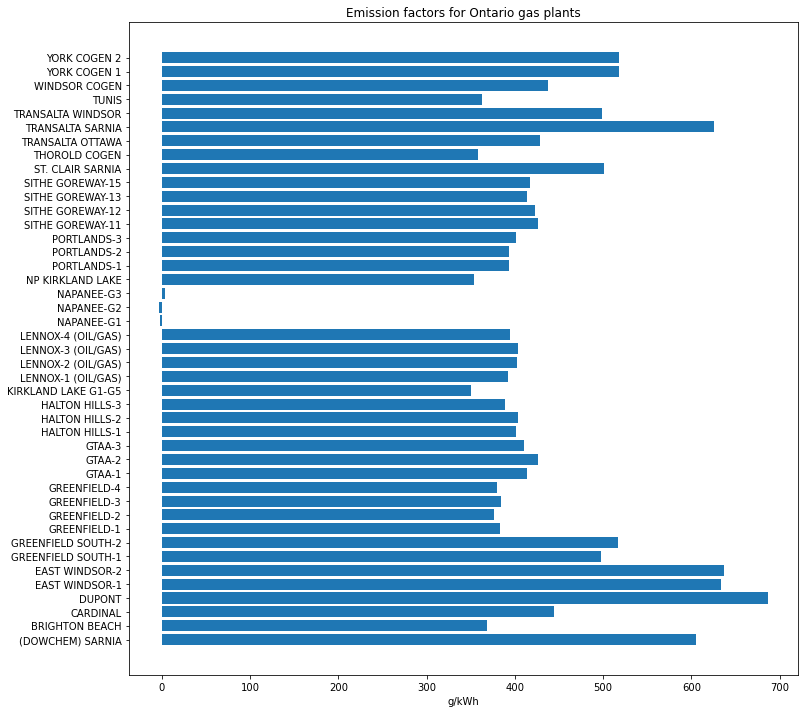

In [3]:
co2_emissions = df_summary['TOTAL EMISSIONS'].str.replace(' tonnes', '').str.replace(',', '').astype(int)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df_output[gas_plants]
y = co2_emissions
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
lr = LinearRegression().fit(X_train, y_train)

print("Training set score: {:.3f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lr.score(X_test, y_test)))

plt.figure(figsize=(12,12))
plt.barh(gas_plants, lr.coef_ * 1000)
plt.title("Emission factors for Ontario gas plants")
plt.xlabel("g/kWh");

In [4]:
import statsmodels.api as sm

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:        TOTAL EMISSIONS   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.237e+06
Date:                Fri, 15 Jul 2022   Prob (F-statistic):                        0.00
Time:                        19:00:48   Log-Likelihood:                         -11566.
No. Observations:                5914   AIC:                                  2.322e+04
Df Residuals:                    5871   BIC:                                  2.351e+04
Df Model:                          43                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

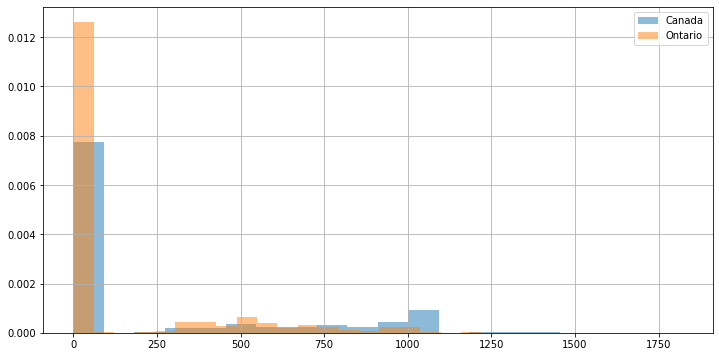

In [5]:
# Emission intensity (g/kWh) of all Canadian and Ontario power plants in the CARMA database
df_carma[df_carma['country'] == 'Canada']['intensity_future'].hist(bins=20, density=True, alpha=0.5, label='Canada')
df_carma[df_carma['region'] == 'Ontario']['intensity_future'].hist(bins=20, density=True, alpha=0.5, label='Ontario')
plt.legend()

In [9]:
# Download IESO historical data
import requests

def download_url(url, ext='.xlsx'):
    filename = os.path.join('data', 'IESO', os.path.splitext(url.split('/')[-1])[0] + ext)
    if not os.path.exists(filename):
        print(f"Download { filename }")
        r = requests.get(url)
        if r.ok:
            with open(filename,'wb') as output_file:
                output_file.write(r.content)
        else:
            print("Error downloading file")

for year in range(2010, 2019):
    url = f"https://ieso.ca/-/media/Files/IESO/Power-Data/data-directory/GOC-{ year }.ashx"
    download_url(url)
    
# Special case: 2019 Jan-Apr
download_url('https://ieso.ca/-/media/Files/IESO/Power-Data/data-directory/GOC-2019-Jan-April.ashx')    

# Rest of 2019
year = 2019
for month in range(6,13):
    url = "http://reports.ieso.ca/public/GenOutputCapabilityMonth/PUB_GenOutputCapabilityMonth_%d%02d.csv" % (year, month)
    download_url(url, ext='.csv')
    
# 2020 to present
for year in range(2020, 2023):
    print(year)
    for month in range(1,13):
        url = "http://reports.ieso.ca/public/GenOutputCapabilityMonth/PUB_GenOutputCapabilityMonth_%d%02d.csv" % (year, month)
        download_url(url, ext='.csv')

2020
2021
2022
Download data\IESO\PUB_GenOutputCapabilityMonth_202207.csv
Download data\IESO\PUB_GenOutputCapabilityMonth_202208.csv
Error downloading file
Download data\IESO\PUB_GenOutputCapabilityMonth_202209.csv
Error downloading file
Download data\IESO\PUB_GenOutputCapabilityMonth_202210.csv
Error downloading file
Download data\IESO\PUB_GenOutputCapabilityMonth_202211.csv
Error downloading file
Download data\IESO\PUB_GenOutputCapabilityMonth_202212.csv
Error downloading file
